In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
from matplotlib import pyplot as plt

sns.set(style="whitegrid")

# Read and heal data

We read the data from https://data.europa.eu/euodp/en/data/dataset/covid-19-coronavirus-data because the dataset is larger than the one from kaggle.
We then remove NaN values and a specific edge case about beeing member of the EU from a japanese flight.

In [2]:
url = 'https://www.ecdc.europa.eu/sites/default/files/documents/COVID-19-geographic-disbtribution-worldwide-2020-03-16.xls'
all_countries = pd.read_excel(url)
all_countries.isna().sum()

DateRep            0
CountryExp         0
NewConfCases       0
NewDeaths          1
GeoId              2
Gaul1Nuts1      4741
EU                 0
dtype: int64

In [3]:
all_countries = all_countries.drop(columns=['Gaul1Nuts1'])
all_countries = all_countries[all_countries['EU'] != 0]

# Data Exploration

In [4]:
all_countries.head()

,DateRep,CountryExp,NewConfCases,NewDeaths,GeoId,EU
0,2020-03-16,Afghanistan,6,0.0,AF,Non-EU/EEA
1,2020-03-15,Afghanistan,3,0.0,AF,Non-EU/EEA
2,2020-03-11,Afghanistan,3,0.0,AF,Non-EU/EEA
3,2020-03-08,Afghanistan,3,0.0,AF,Non-EU/EEA
4,2020-03-02,Afghanistan,0,0.0,AF,Non-EU/EEA


In [5]:
all_countries['CountryExp'].unique().shape[0]

142

### Search for outliers in the number of confirmed cases first

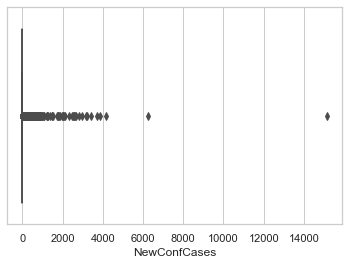

In [6]:
sns.boxplot(x="NewConfCases", data=all_countries);

In [7]:
summed = all_countries.groupby(['CountryExp']).sum()
summed[summed['NewConfCases'] > 10000]

,NewConfCases,NewDeaths
CountryExp,,
China,81020,3217.0
Iran,13938,724.0
Italy,23980,1811.0


In [8]:
outliers = all_countries[all_countries['NewConfCases'] > 5000]['CountryExp'].values
outliers

array(['China', 'Italy'], dtype=object)

In [9]:
without_china = all_countries[all_countries['CountryExp'] != 'China']
without_outliers = all_countries[all_countries['CountryExp'] != outliers[0]]

for outlier in outliers:
    without_outliers = without_outliers[without_outliers['CountryExp'] != outlier]

without_outliers['NewConfCases'].mean(), all_countries['NewConfCases'].mean()

(12.26510333863275, 32.147705360586194)

## Plot new infections over time

In [10]:
new_cases = all_countries.groupby(['DateRep']).sum()
days_passed = new_cases.shape[0]
sns.set(rc={'figure.figsize':(12,10)})

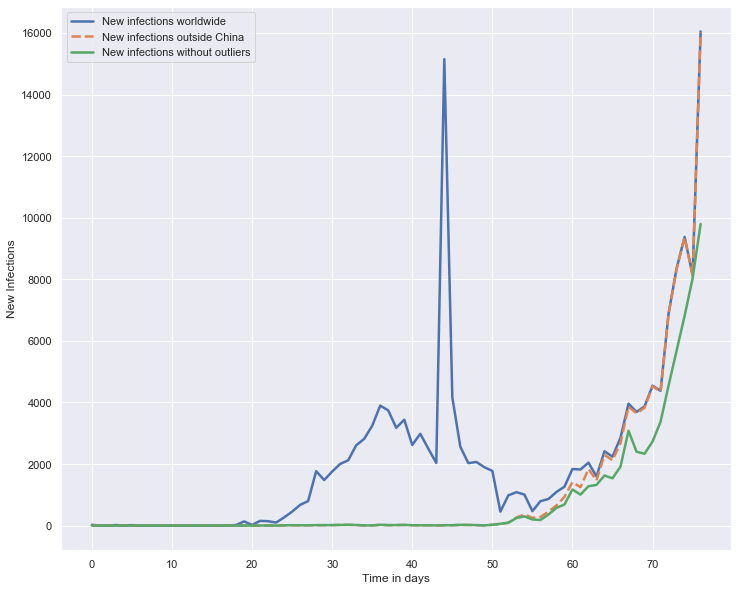

In [11]:
plt.plot(range(days_passed), new_cases['NewConfCases'].values, linewidth=2.5, label='New infections worldwide');
plt.plot(range(days_passed), without_china.groupby(['DateRep']).sum()['NewConfCases'].values, linewidth=2.5, linestyle='dashed', label='New infections outside China');
plt.plot(range(days_passed), without_outliers.groupby(['DateRep']).sum()['NewConfCases'].values, linewidth=2.5, label='New infections without outliers');
plt.legend()
plt.xlabel('Time in days')
plt.ylabel('New Infections');

In [12]:
sns.set(rc={'figure.figsize':(8,6)})

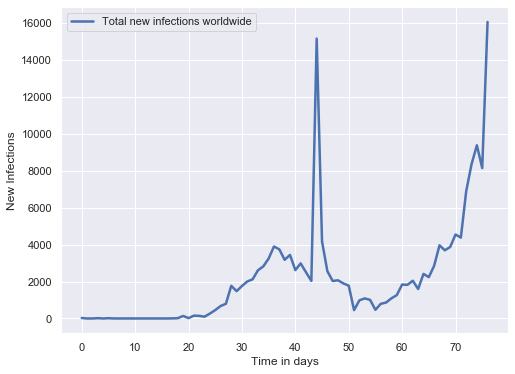

In [13]:
plt.plot(range(days_passed), new_cases['NewConfCases'].values, linewidth=2.5);
plt.legend(['Total new infections worldwide'])
plt.xlabel('Time in days')
plt.ylabel('New Infections');

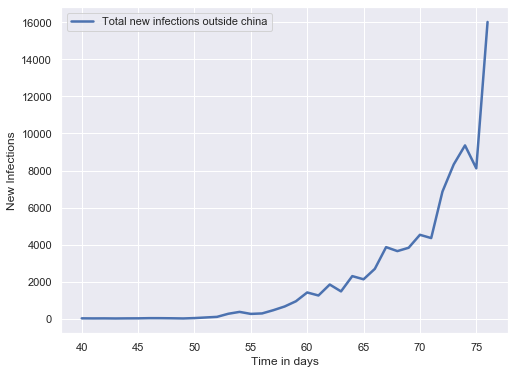

In [14]:
plt.plot(range(40, days_passed), without_china.groupby(['DateRep']).sum()['NewConfCases'].values[40:], linewidth=2.5);
plt.legend(['Total new infections outside china'])
plt.xlabel('Time in days')
plt.ylabel('New Infections');

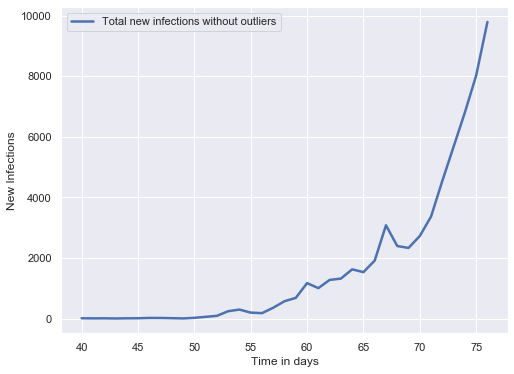

In [15]:
plt.plot(range(40, days_passed), without_outliers.groupby(['DateRep']).sum()['NewConfCases'].values[40:], linewidth=2.5);
plt.legend(['Total new infections without outliers'])
plt.xlabel('Time in days')
plt.ylabel('New Infections');

### Distribution of the new confirmed cases

### New cases andnew  deaths correlation

We look for correlation between new confirmed cases and new deaths.
We plot the obvious linear relationship with a 95% confidence intervall.

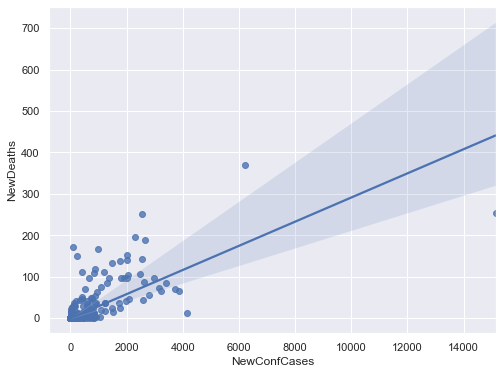

In [16]:
sns.regplot(x="NewConfCases", y="NewDeaths", data=all_countries);

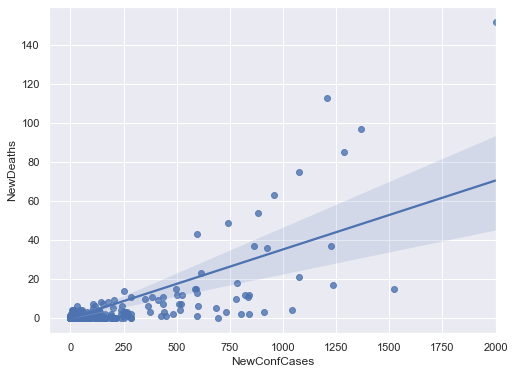

In [17]:
sns.regplot(x="NewConfCases", y="NewDeaths", data=without_outliers);

The outliers China and Italy display high mortality rate from the start.
For the rest of the world we could try to describe the relation between infections and deaths as follwing.

When the number of new infections is low, so is death ratio. At around 600 new daily infection we see the death ratio rising above our linear relationship in some countries.

Maybe we can explain this correlation with a causal relationship like the overload of the health care system.
It's not unlikely either that the death ratio is low at the beginning because people just started to get infected and aren't at the critial point of Covid19 yet.

In [18]:
sns.set(rc={'figure.figsize':(12,10)})

### Group by EU membership

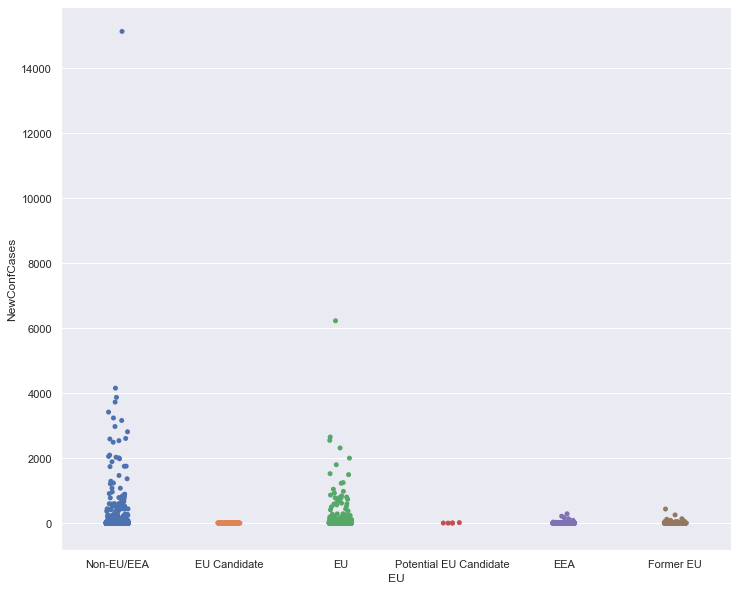

In [19]:
sns.stripplot(x="EU", y="NewConfCases", data=all_countries);

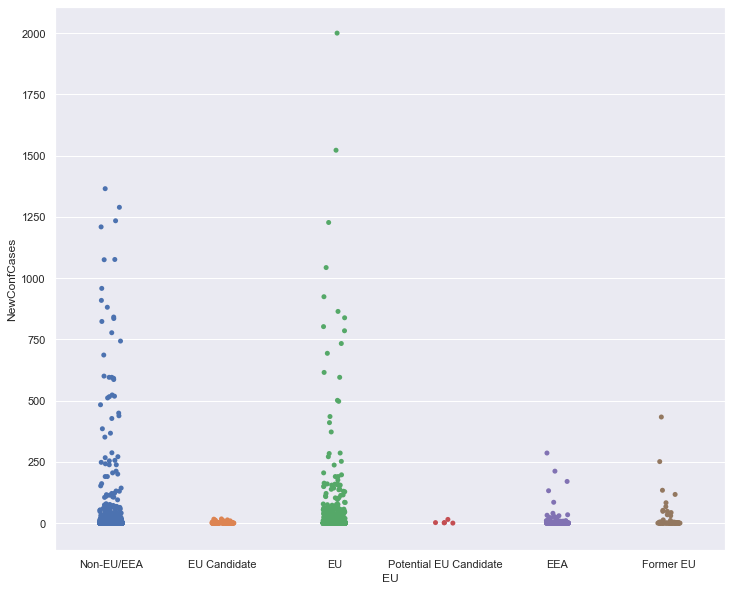

In [20]:
sns.stripplot(x="EU", y="NewConfCases", data=without_outliers);

In [21]:
sns.set(rc={'figure.figsize':(8,6)})

In [22]:
all_countries.groupby(['DateRep','CountryExp']).sum()

NewConfCases  NewDeaths
DateRep    CountryExp                                       
2019-12-31 Afghanistan                          0        0.0
           Algeria                              0        0.0
           Armenia                              0        0.0
           Australia                            0        0.0
           Austria                              0        0.0
...                                           ...        ...
2020-03-16 United States of America           823       12.0
           Uruguay                              2        0.0
           Uzbekistan                           6        0.0
           Venezuela                            5        0.0
           Vietnam                              4        0.0

[5186 rows x 2 columns]

In [23]:
foo = all_countries.groupby(['CountryExp','DateRep']).sum().groupby(['DateRep'])
foo = foo.head(74)
foo

NewConfCases  NewDeaths
CountryExp  DateRep                            
Afghanistan 2019-12-31             0        0.0
            2020-01-01             0        0.0
            2020-01-02             0        0.0
            2020-01-03             0        0.0
            2020-01-04             0        0.0
...                              ...        ...
Vietnam     2020-03-02             0        0.0
            2020-03-07             1        0.0
            2020-03-08             4        0.0
            2020-03-09             9        0.0
            2020-03-10             1        0.0

[5032 rows x 2 columns]

In [24]:
foo.shape[0] / all_countries['CountryExp'].unique().shape[0]

35.436619718309856